In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from TargetDistributions.Guassian_FullCov import Guassian_FullCov
from FittedModels.Models.DiagonalGaussian import DiagonalGaussian
from AIS_train.AnnealedImportanceSampler import AnnealedImportanceSampler
from TargetDistributions.MoG import MoG
from FittedModels.Models.FlowModel import FlowModel
from TargetDistributions.DoubleWell import ManyWellEnergy
from FittedModels.utils.plotting_utils import plot_samples_vs_contours_many_well, plot_history
from Utils.numerical_utils import quadratic_function as expectation_function

# 2D Double Well Problem Initial Test

In [20]:
n_samples_expectation = int(1e4)
torch.manual_seed(2)
epochs = 20
dim = 2
n_samples_estimation = int(1e4)
sample_size = int(1e3)
n_intermediate_distributions = 10

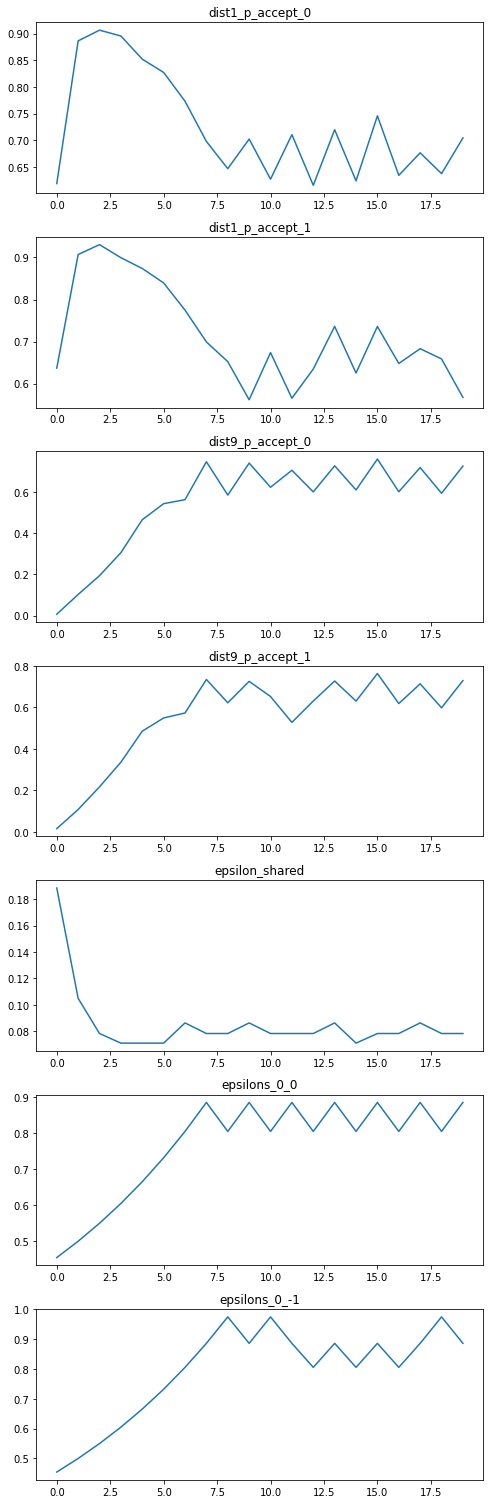

In [21]:
target = ManyWellEnergy(dim)
class tester:
    target_dist = target
    device = "cpu"
learnt_sampler = DiagonalGaussian(dim)
test = AnnealedImportanceSampler(loss_type=False, train_parameters=False,
                                 sampling_distribution=learnt_sampler,
                                 target_distribution=target, n_distributions=n_intermediate_distributions + 2,
                                 n_steps_transition_operator=2,
                                 transition_operator="HMC")
history = {}
history.update(dict([(key, []) for key in test.transition_operator_class.interesting_info()]))
for i in range(epochs):
    x_new, log_w = test.run(sample_size)
    transition_operator_info = test.transition_operator_class.interesting_info()
    for key in transition_operator_info:
        history[key].append(transition_operator_info[key])
plot_history(history)

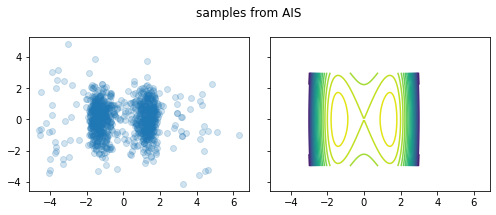

In [22]:
plot_samples_vs_contours_many_well(tester, n_samples=None,
                                       title=f"samples from AIS",
                                       samples_q=x_new, alpha=0.2)

In [23]:
torch.manual_seed(0)
expectation, info_dict = test.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function,
                                                                    batch_size=int(1e3),
                                                                    drop_nan_and_infs=True)
print(f"ESS for samples from AIS  "\
        f"{info_dict['effective_sample_size'].item()/ n_samples_expectation}" \
        f" calculated using {n_samples_expectation} samples \n")

torch.manual_seed(1)
expectation, info_dict = test.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function,
                                                                    batch_size=int(1e3),
                                                                    drop_nan_and_infs=True)
print(f"ESS for samples from AIS  "\
        f"{info_dict['effective_sample_size'].item()/ n_samples_expectation}" \
        f" calculated using {n_samples_expectation} samples \n")

ESS for samples from AIS  0.5493921605060538 calculated using 10000 samples 

ESS for samples from AIS  0.5511592981967026 calculated using 10000 samples 



# Functionize

In [13]:
def test_problem(n_intermediate_distributions, dim, 
                 n_samples_expectation = int(1e4), seed=2, tuning_period = 20, sample_size = int(1e3),
                n_outer=1):
    
    torch.manual_seed(seed)
    target = ManyWellEnergy(dim)
    class tester:
        target_dist = target
        device = "cpu"
    learnt_sampler = DiagonalGaussian(dim)
    HMC_transition_args = {"step_tuning_method":  "p_accept", "n_outer":n_outer} 
    test = AnnealedImportanceSampler(loss_type=False,
                                     sampling_distribution=learnt_sampler,
                                     target_distribution=target, n_distributions=n_intermediate_distributions + 2,
                                     transition_operator="HMC", transition_operator_kwargs=HMC_transition_args)
    history = {}
    history.update(dict([(key, []) for key in test.transition_operator_class.interesting_info()]))
    for i in range(tuning_period):
        x_new, log_w = test.run(sample_size)
    torch.manual_seed(0)
    expectation, info_dict = test.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function,
                                                                    batch_size=n_samples_expectation,
                                                                    drop_nan_and_infs=True)
    ESS1 = info_dict['effective_sample_size'].item()/ n_samples_expectation
    torch.manual_seed(1)
    expectation, info_dict = test.calculate_expectation(n_samples_expectation,
                                                                        expectation_function=expectation_function,
                                                                        batch_size=n_samples_expectation,
                                                                        drop_nan_and_infs=True)
    ESS2 = info_dict['effective_sample_size'].item()/ n_samples_expectation
    return ESS1, ESS2

In [14]:
ESS1, ESS2 = test_problem(n_intermediate_distributions=1, dim=2)
ESS1, ESS2 

(0.2900852520429369, 0.30135539194656674)

# Scaling with number of distributions

In [11]:
n_points = 10
max_dist = 40
n_intermediate_dist_options = np.linspace(0, max_dist, n_points, dtype="int")
ESS_hist = np.zeros((2, n_points))
for i, n_itermediate_dist in enumerate(n_intermediate_dist_options):
    ESS1, ESS2 = test_problem(n_intermediate_distributions=n_itermediate_dist, dim=2)
    ESS_hist[0, i], ESS_hist[1, i] = ESS1, ESS2

Text(0, 0.5, 'effective sample size')

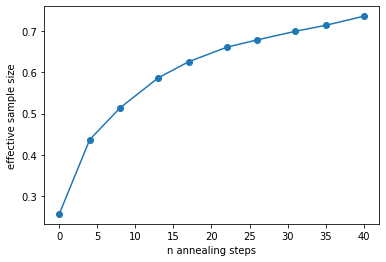

In [12]:
plt.plot(n_intermediate_dist_options, ESS_hist[0, :], "-o")
plt.xlabel("n annealing steps")
plt.ylabel("effective sample size")

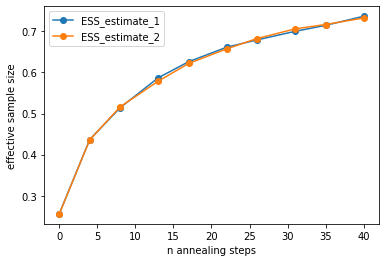

In [13]:
plt.plot(n_intermediate_dist_options, ESS_hist[0, :], "-o")
plt.plot(n_intermediate_dist_options, ESS_hist[1, :], "-o")
plt.xlabel("n annealing steps")
plt.ylabel("effective sample size")
plt.legend(["ESS_estimate_1", "ESS_estimate_2"])

# Scaling with distributions, with different "quality" of transition operator

In [20]:
n_points = 10
max_dist = 40
n_intermediate_dist_options = np.linspace(0, max_dist, n_points, dtype="int")
ESS_hist_good = np.zeros((2, n_points))
ESS_hist_bad = np.zeros((2, n_points))
for i, n_itermediate_dist in enumerate(n_intermediate_dist_options):
    ESS1, ESS2 = test_problem(n_intermediate_distributions=n_itermediate_dist, dim=2)
    ESS_hist_good[0, i], ESS_hist_good[1, i] = ESS1, ESS2
    ESS1, ESS2 = test_problem(n_intermediate_distributions=n_itermediate_dist, dim=2, tuning_period=0)
    ESS_hist_bad[0, i], ESS_hist_bad[1, i] = ESS1, ESS2

In [23]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

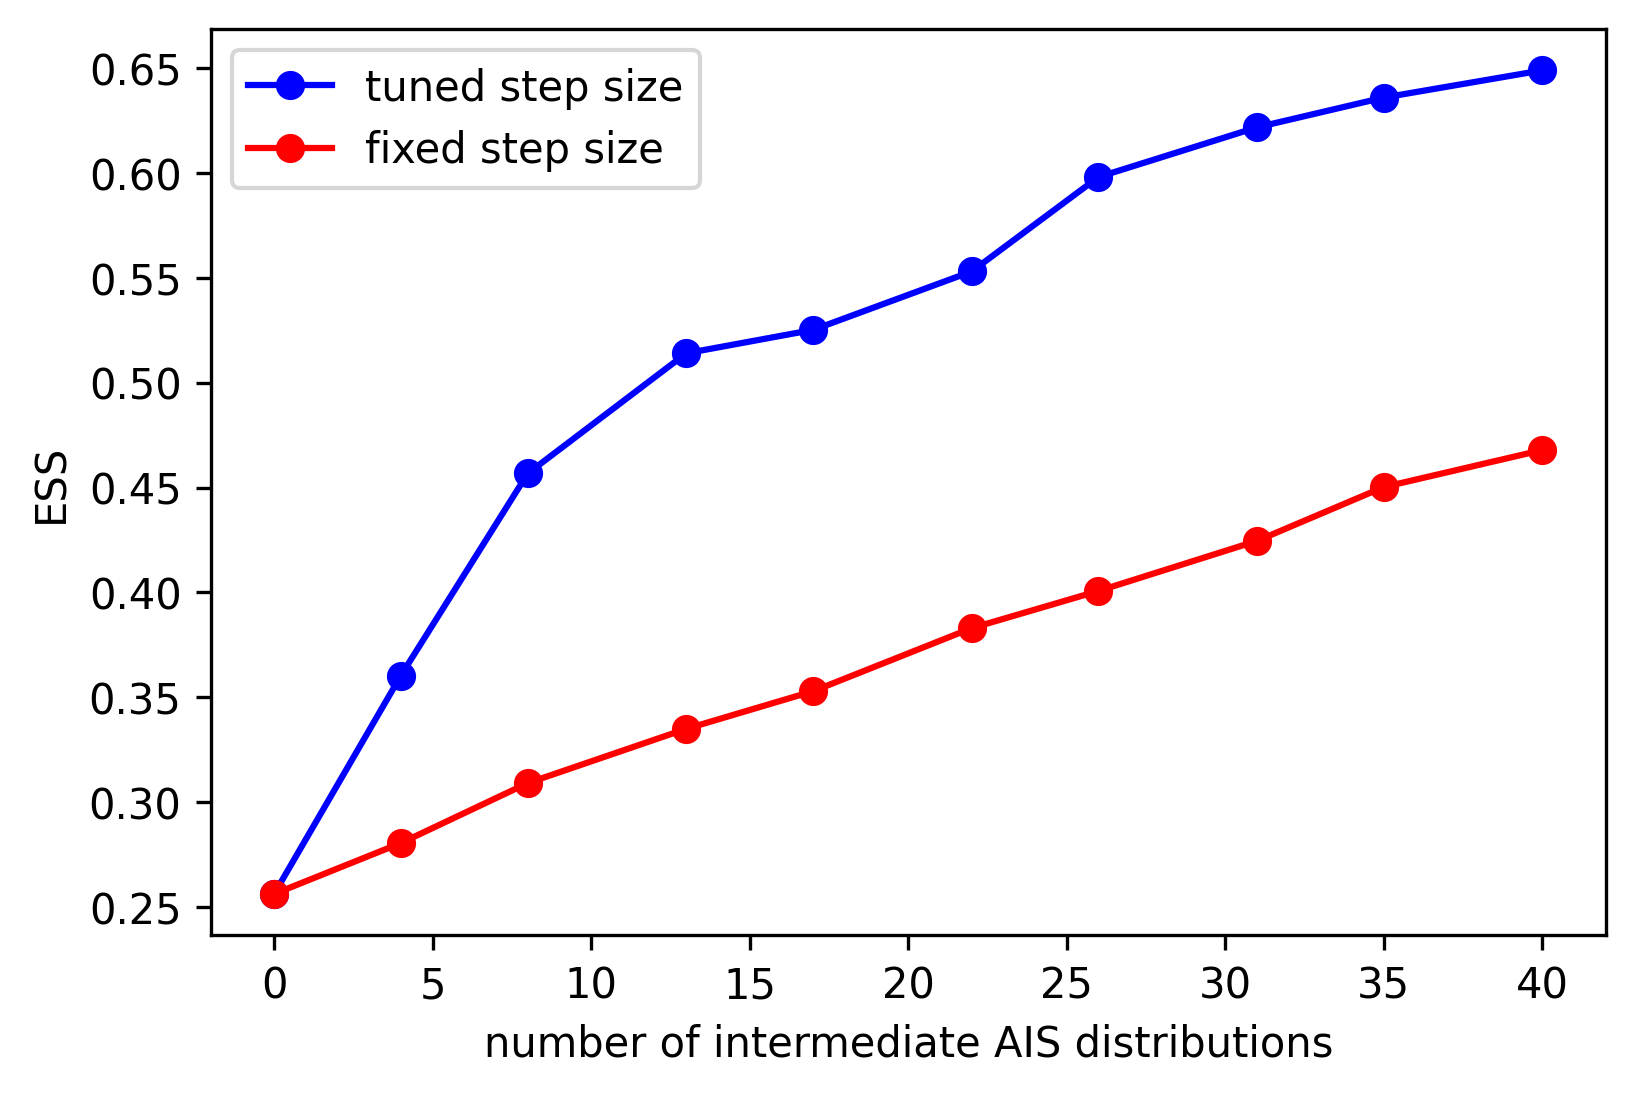

In [25]:
plt.plot(n_intermediate_dist_options, ESS_hist_good[0, :], "-o", c="blue")
plt.plot(n_intermediate_dist_options, ESS_hist_bad[0, :], "-o", c="red")
plt.xlabel("number of intermediate AIS distributions")
plt.ylabel("ESS")
plt.legend(["tuned step size", "fixed step size"])

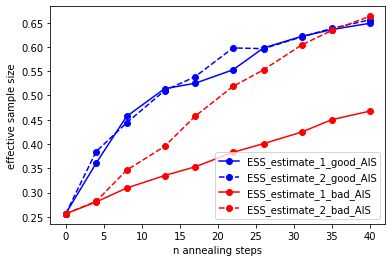

In [22]:
plt.plot(n_intermediate_dist_options, ESS_hist_good[0, :], "-o", c="blue")
plt.plot(n_intermediate_dist_options, ESS_hist_good[1, :], "--o", c="blue")
plt.plot(n_intermediate_dist_options, ESS_hist_bad[0, :], "-o", c="red")
plt.plot(n_intermediate_dist_options, ESS_hist_bad[1, :], "--o", c="red")
plt.xlabel("n annealing steps")
plt.ylabel("effective sample size")
plt.legend(["ESS_estimate_1_good_AIS", "ESS_estimate_2_good_AIS", "ESS_estimate_1_bad_AIS", "ESS_estimate_2_bad_AIS"])

# On Higher Dimensional Problems

In [17]:
dim = 8
n_points = 10
max_dist = 20
n_intermediate_dist_options = np.linspace(0, max_dist, n_points, dtype="int")
ESS_hist_good = np.zeros((2, n_points))
ESS_hist_bad = np.zeros((2, n_points))
for i, n_itermediate_dist in enumerate(n_intermediate_dist_options):
    ESS1, ESS2 = test_problem(n_intermediate_distributions=n_itermediate_dist, dim=dim, n_samples_expectation = int(2e5))
    ESS_hist_good[0, i], ESS_hist_good[1, i] = ESS1, ESS2
    ESS1, ESS2 = test_problem(n_intermediate_distributions=n_itermediate_dist, dim=dim, n_steps_transition_operator=1, 
                              tuning_period=0, n_samples_expectation = int(2e5))
    ESS_hist_bad[0, i], ESS_hist_bad[1, i] = ESS1, ESS2

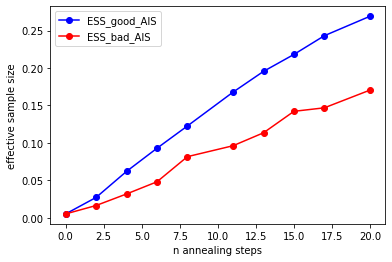

In [18]:
plt.plot(n_intermediate_dist_options, ESS_hist_good[0, :], "-o", c="blue")
plt.plot(n_intermediate_dist_options, ESS_hist_bad[0, :], "-o", c="red")
plt.xlabel("n annealing steps")
plt.ylabel("effective sample size")
plt.legend(["ESS_good_AIS", "ESS_bad_AIS"])

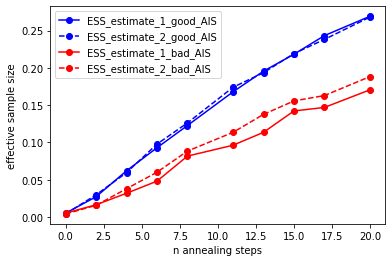

In [19]:
plt.plot(n_intermediate_dist_options, ESS_hist_good[0, :], "-o", c="blue")
plt.plot(n_intermediate_dist_options, ESS_hist_good[1, :], "--o", c="blue")
plt.plot(n_intermediate_dist_options, ESS_hist_bad[0, :], "-o", c="red")
plt.plot(n_intermediate_dist_options, ESS_hist_bad[1, :], "--o", c="red")
plt.xlabel("n annealing steps")
plt.ylabel("effective sample size")
plt.legend(["ESS_estimate_1_good_AIS", "ESS_estimate_2_good_AIS", "ESS_estimate_1_bad_AIS", "ESS_estimate_2_bad_AIS"])